In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import yfinance as yf
import datetime

In [ ]:
# --- 1. Data Collection ---
# Define the stock ticker and date range
ticker = "AAPL"
start_date = datetime.datetime(2020, 1, 1)
end_date = datetime.datetime(2025, 7, 30) # Using a recent date for the example

print(f"Downloading {ticker} stock data from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}...")
data = yf.download(ticker, start=start_date, end=end_date)

if data.empty:
    print(f"No data downloaded for {ticker}. Please check the ticker symbol or date range.")
    exit()

print("Data Head:")
print(data.head())
print("\nData Info:")
data.info()

# Use only the 'Close' price for this example
# You can expand this to include 'Open', 'High', 'Low', 'Volume' as multiple features
close_prices = data['Close'].values.reshape(-1, 1)

/tmp/ipython-input-439940773.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Data Head:
Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2020-01-02  72.620842  72.681289  71.373218  71.627092  135480400
2020-01-03  71.914818  72.676447  71.689957  71.847118  146322800
2020-01-06  72.487854  72.526541  70.783256  71.034717  118387200
2020-01-07  72.146942  72.753823  71.926915  72.497529  108872000
2020-01-08  73.307510  73.609745  71.849533  71.849533  132079200

Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1400 entries, 2020-01-02 to 2025-07-29
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   1400 non-null   float64
 1   (High, AAPL)    1400 non-null   float64
 2   (Low, AAPL)     1400 non-null   float64
 3   (Open, AAPL)    1400 non-null   float64
 4   (Volume, AAPL)  1400 non-null   int64  
dtypes: fl

In [ ]:
# --- 2. Data Preprocessing ---

# Splitting data into training and test sets
# IMPORTANT: Split chronologically for time series data
train_size = int(len(close_prices) * 0.8) # 80% for training
train_data = close_prices[0:train_size, :]
test_data = close_prices[train_size:len(close_prices), :]

print(f"\nTraining data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

# Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler ONLY on the training data and transform both train and test data
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

# Create sequences for LSTM
# Function to create dataset with look_back window
def create_sequences(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 60 # Number of previous days to consider for prediction (e.g., 60 days)
X_train, y_train = create_sequences(train_scaled, look_back)
X_test, y_test = create_sequences(test_scaled, look_back)

# Reshape input to be [samples, timesteps, features] for LSTM
# In this case, features = 1 (only 'Close' price)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(f"\nShape of X_train after reshaping: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test after reshaping: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")



Training data shape: (1120, 1)
Test data shape: (280, 1)

Shape of X_train after reshaping: (1060, 60, 1)
Shape of y_train: (1060,)
Shape of X_test after reshaping: (220, 60, 1)
Shape of y_test: (220,)


In [ ]:
# --- 3. RNN Model Architecture ---

model = Sequential()

# First LSTM layer with return_sequences=True to stack another LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
model.add(Dropout(0.2)) # Add dropout for regularization to prevent overfitting

# Second LSTM layer (optional, can be removed for a simpler model)
# return_sequences=False because this is the last LSTM layer before the Dense output
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer - Dense layer with 1 unit for predicting the next single price
# No activation function for regression (linear activation)
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

print("\nModel Summary:")
model.summary()

# --- 4. Training & Evaluation ---

print("\nTraining the model...")
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)


Training the model...
Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0890 - val_loss: 0.0018
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0075 - val_loss: 0.0024
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0051 - val_loss: 0.0022
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0041 - val_loss: 0.0028
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0044 - val_loss: 0.0030
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0046 - val_loss: 0.0022
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0039 - val_loss: 0.0015
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0038 - val_loss: 0.0015
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0037 - val_loss: 0.0016
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - val_loss: 0.0014
Epoch 11/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0036 - val_loss: 0.0022
Epoch 12/100
30/30 ━━━━━━━━━━

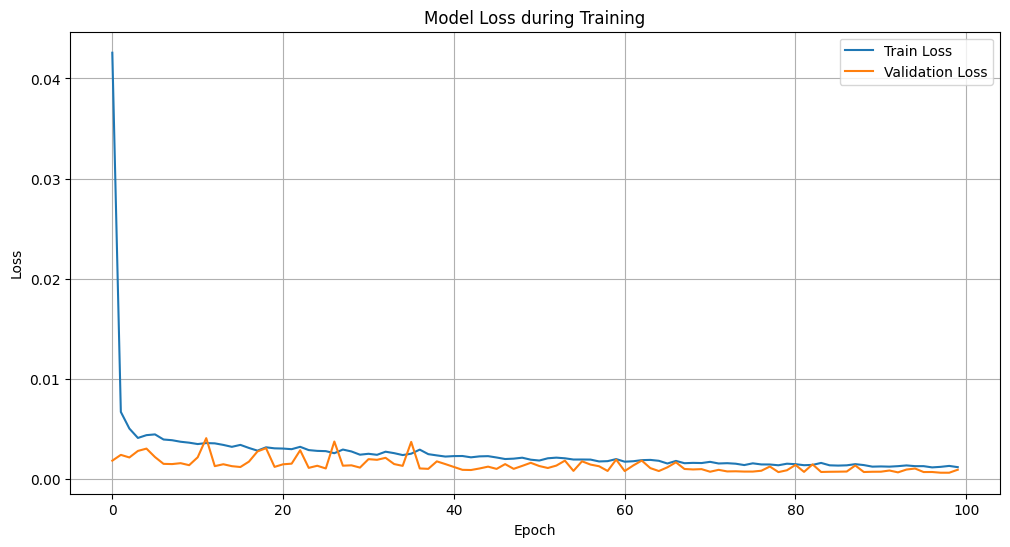


Making predictions on the test set...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Evaluation Metrics on Test Set:
Root Mean Squared Error (RMSE): 7.13
Mean Absolute Error (MAE): 5.81


In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss during Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Make predictions on the test set
print("\nMaking predictions on the test set...")
y_pred_scaled = model.predict(X_test)

# Inverse transform the predictions and actual values back to original scale
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)) # Reshape y_test for inverse_transform

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
mae = mean_absolute_error(y_test_original, y_pred)

print(f"\nEvaluation Metrics on Test Set:")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")


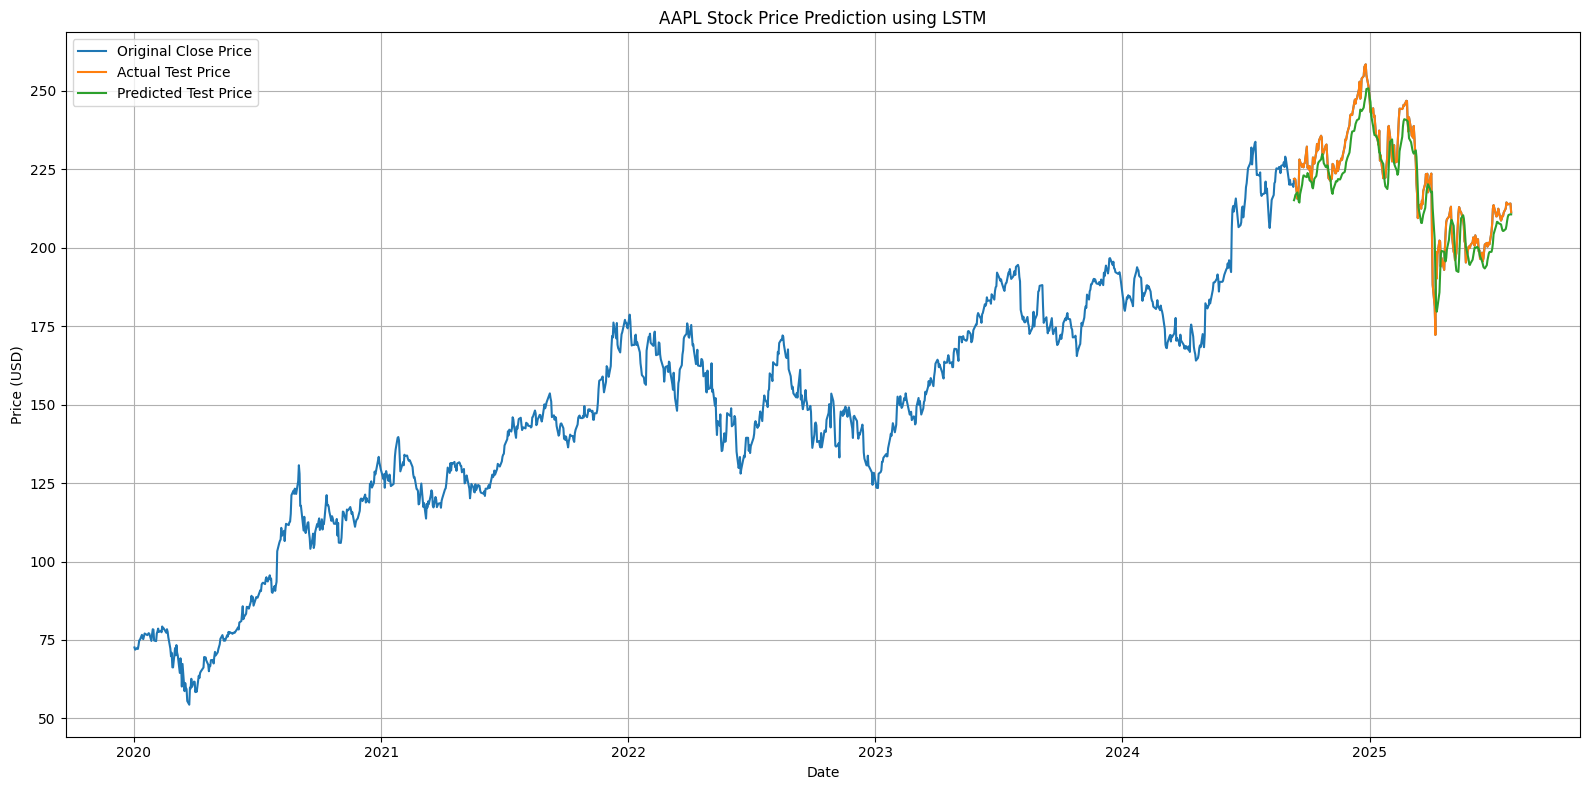

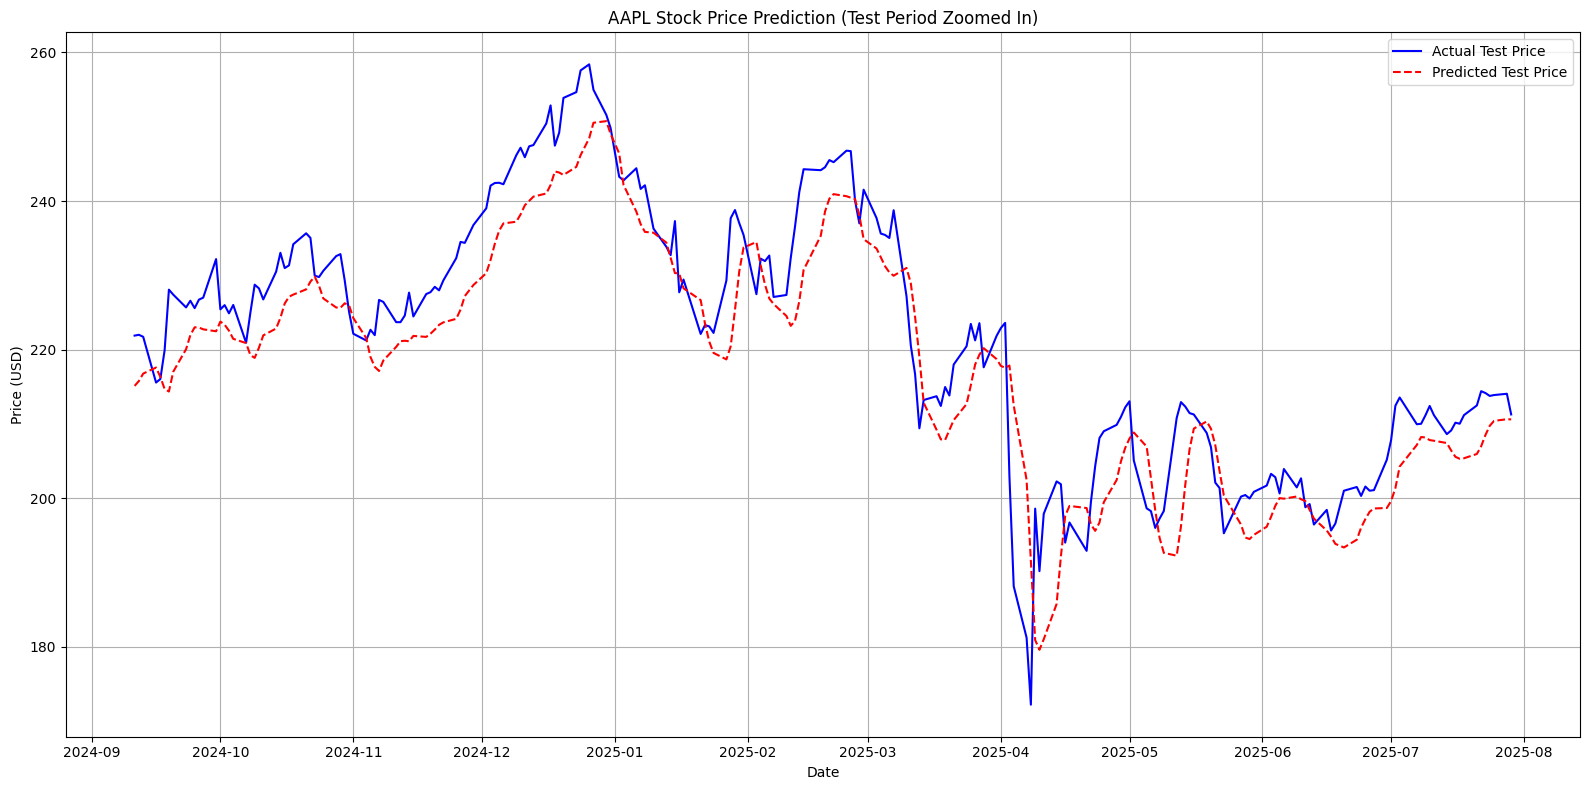

In [ ]:
# --- 5. Visualization of Results ---

# Prepare data for plotting (aligning predictions with original dates)
# Get the dates for the test set
test_dates = data.index[train_size + look_back:] # Skip the initial look_back window in test set

plt.figure(figsize=(16, 8))
plt.plot(data.index, close_prices, label='Original Close Price') # Plot full original data
plt.plot(test_dates, y_test_original, label='Actual Test Price')
plt.plot(test_dates, y_pred, label='Predicted Test Price')
plt.title(f'{ticker} Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Plot a zoomed-in view of the test predictions vs actual
plt.figure(figsize=(16, 8))
plt.plot(test_dates, y_test_original, label='Actual Test Price', color='blue')
plt.plot(test_dates, y_pred, label='Predicted Test Price', color='red', linestyle='--')
plt.title(f'{ticker} Stock Price Prediction (Test Period Zoomed In)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
